<a href="https://www.kaggle.com/code/rucheiitr/multi-class-prediction-of-obesity-risk?scriptVersionId=171365702" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Problem Description: 
This Notebook is based on the Multi-Class Prediction of Obesity Risk (Playground Series - Season 4, Episode 2)((https://www.kaggle.com/competitions/playground-series-s4e2/data)). The notebook uses different Machine Learning techniques to predict obesity risk in individuals, which is related to cardiovascular diseas.

# Dataset Description:
The dataset for this competition (both train and test) was generated from a deep learning model trained on the Obesity or CVD risk dataset (https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster).

# Notebook Description
This notebook provides the various steps taken to develop the model.
* Importing the Libraries
* Exploratory Data Analysis
* Feature Engineering
* Data Pre-processing
* Model Selection - LGBM Classifier
* Model Selection - XGB Classifier
* Model Selection - Catboost Classifier
* Final Model

# Importing the Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler,OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import ks_2samp
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier



In [2]:
#convert data into numpy dataframes
df_train=pd.read_csv("/kaggle/input/playground-series-s4e2/train.csv",encoding='windows-1252' )
df_test=pd.read_csv("/kaggle/input/playground-series-s4e2/test.csv", encoding='windows-1252')

# Exploratory Data Analysis

In [3]:
df_train.shape

(20758, 18)

In [4]:
df_test.shape

(13840, 17)

In [5]:
df_train.dtypes

id                                  int64
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [7]:
df_train.isnull().sum()

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [8]:
df_train['NObeyesdad'].unique()

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
       'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I',
       'Obesity_Type_I'], dtype=object)

In [9]:
df_train.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5992.46278,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,10378.50000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,15567.75000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,20757.00000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


In [10]:
#Determine the features which are cateogrical and how many categories of values exists
df_categorical=df_train.select_dtypes(include="object").columns
df_categorical


Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [11]:
df_float=df_train.select_dtypes(include="float").columns
df_float

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')

9


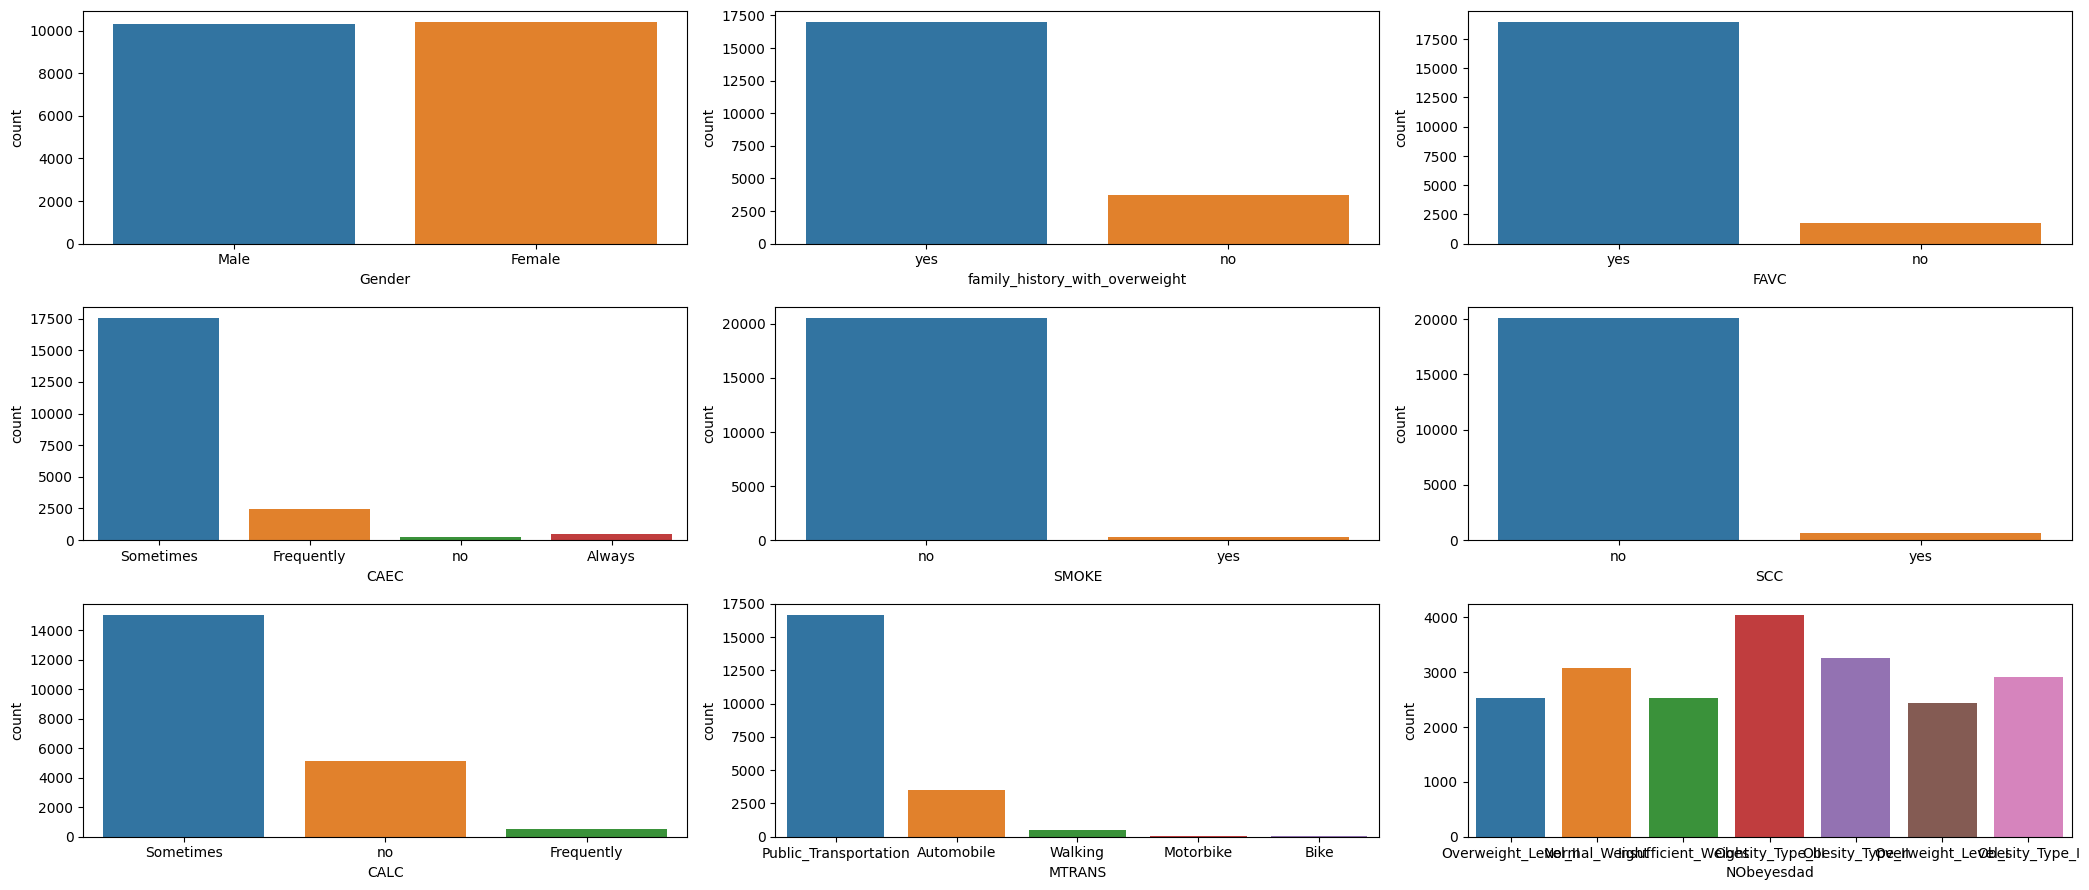

In [12]:
total=len(df_categorical)
print(total)
i=0
fig,axs=plt.subplots(3,3, figsize=(21,9))
c=0
while(i <total):
    var=df_categorical[i:i+3]
    #sns.countplot(data=df_train, x="Gender", order=df_train['Gender'].value_counts(ascending=True).index,palette='Set2', ax=axs[0,0])
    sns.countplot(data=df_train, x=var[0], ax=axs[c,0])
    sns.countplot(data=df_train, x=var[1], ax=axs[c,1])
    sns.countplot(data=df_train, x=var[2], ax=axs[c,2])
    plt.tight_layout()
    c=c+1
    i=i+3
plt.show()

In [13]:
def plot_count(df,columns,n_cols,hue):
    '''
    # Function to genear countplot
    df: total data
    columns: category variables
    n_cols: num of cols
    '''
    n_rows = (len(columns) - 1) // n_cols + 1
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(21, 4 * n_rows))
    ax = ax.flatten()
    
    for i, column in enumerate(columns):
        sns.countplot(data=df, x=column, ax=ax[i],hue=hue)

        # Titles
        ax[i].set_title(f'{column} Counts', fontsize=18)
        ax[i].set_xlabel(None, fontsize=16)
        ax[i].set_ylabel(None, fontsize=16)
        ax[i].tick_params(axis='x', rotation=90)

        for p in ax[i].patches:
            value = int(p.get_height())
            ax[i].annotate(f'{value:.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                           ha='center', va='bottom', fontsize=9)

    ylim_top = ax[i].get_ylim()[1]
    ax[i].set_ylim(top=ylim_top * 1.1)
    for i in range(len(columns), len(ax)):
        ax[i].axis('off')

    # fig.suptitle(plotname, fontsize=25, fontweight='bold')
    plt.tight_layout()
    plt.show()
    

In [14]:
columns_cat = [column for column in df_train.columns if df_train[column].nunique() < 7 and column != "NObeyesdad"]

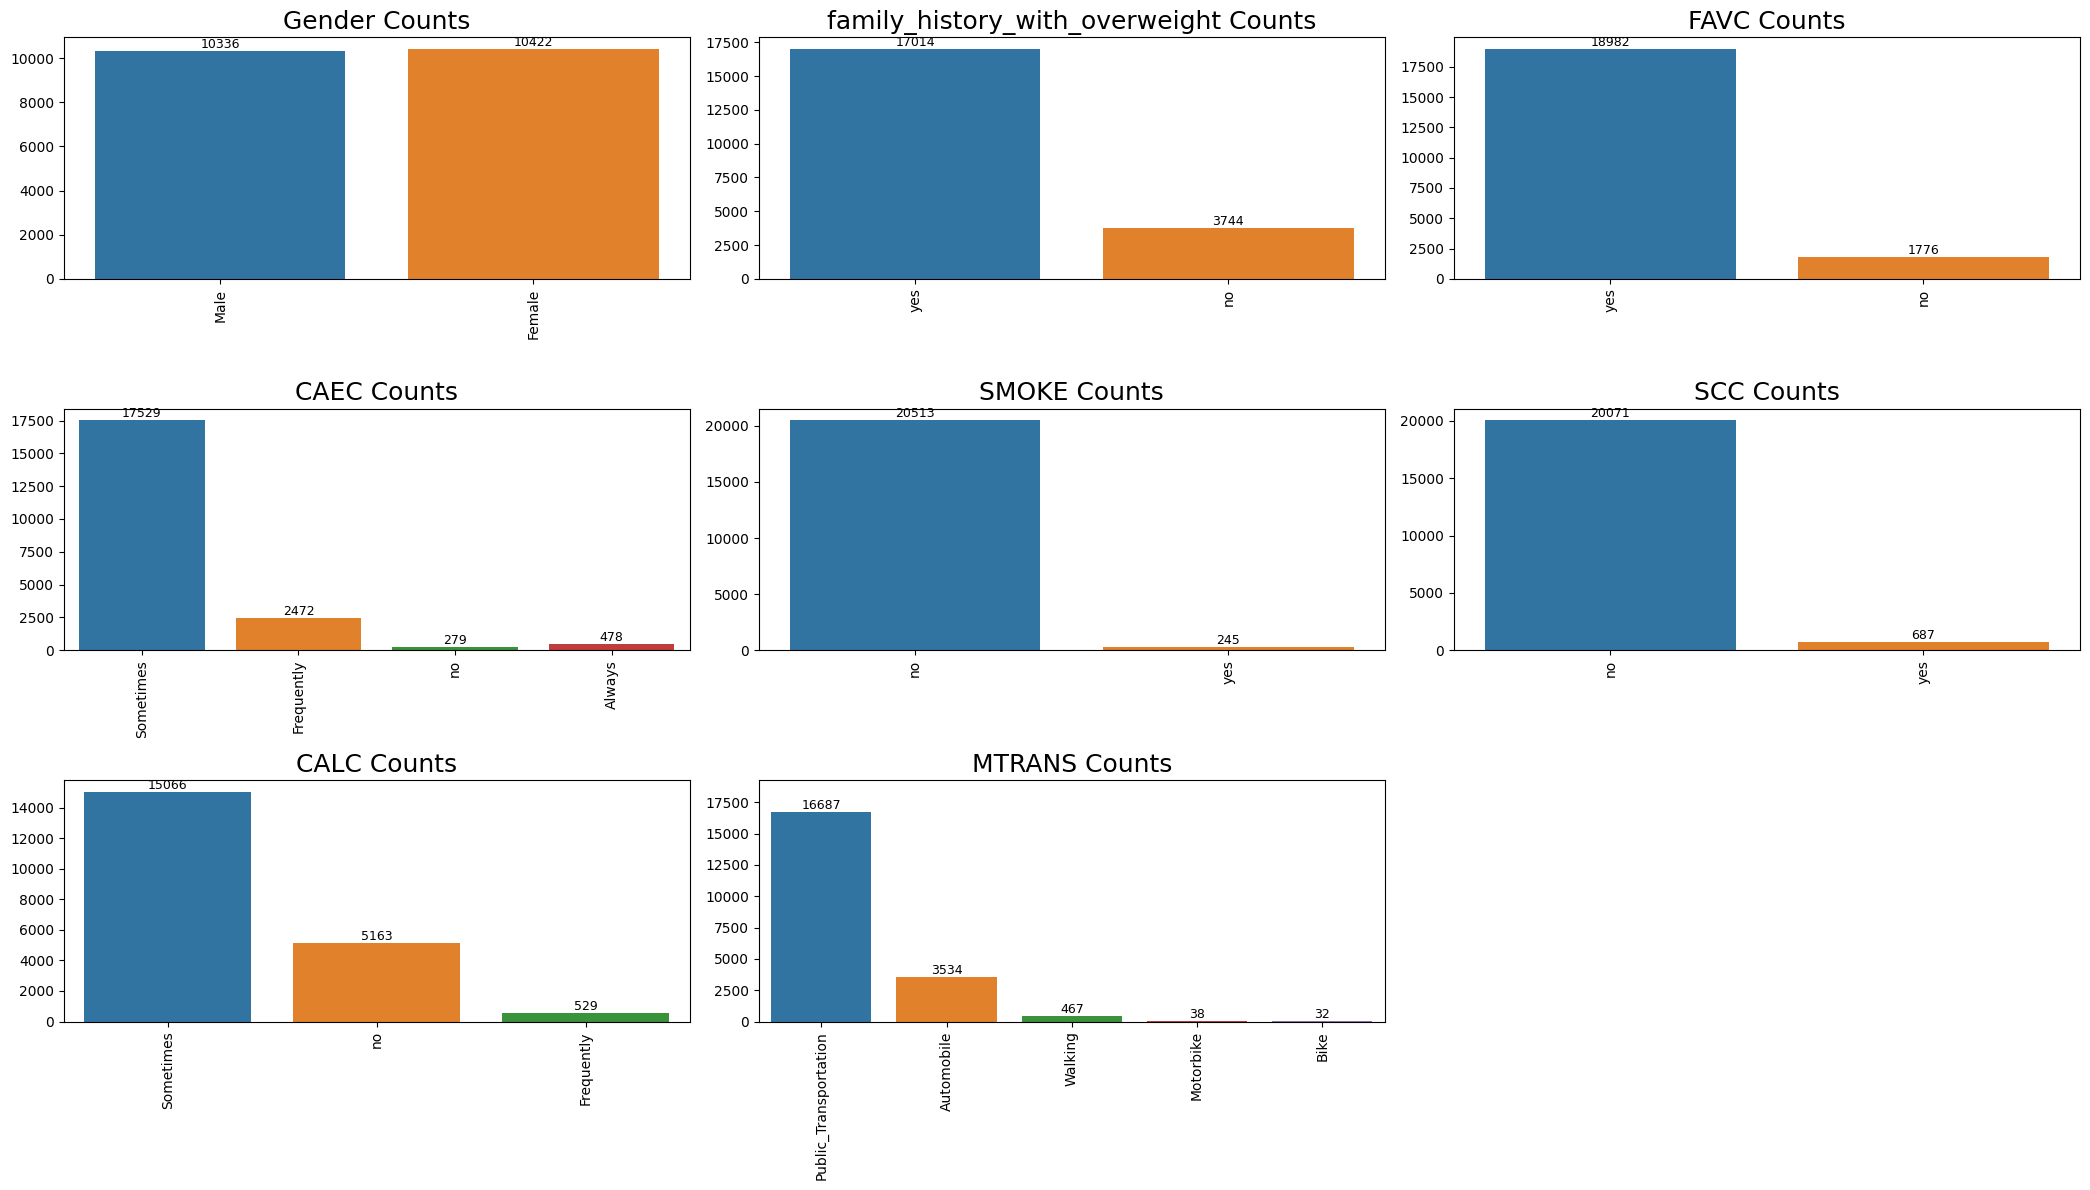

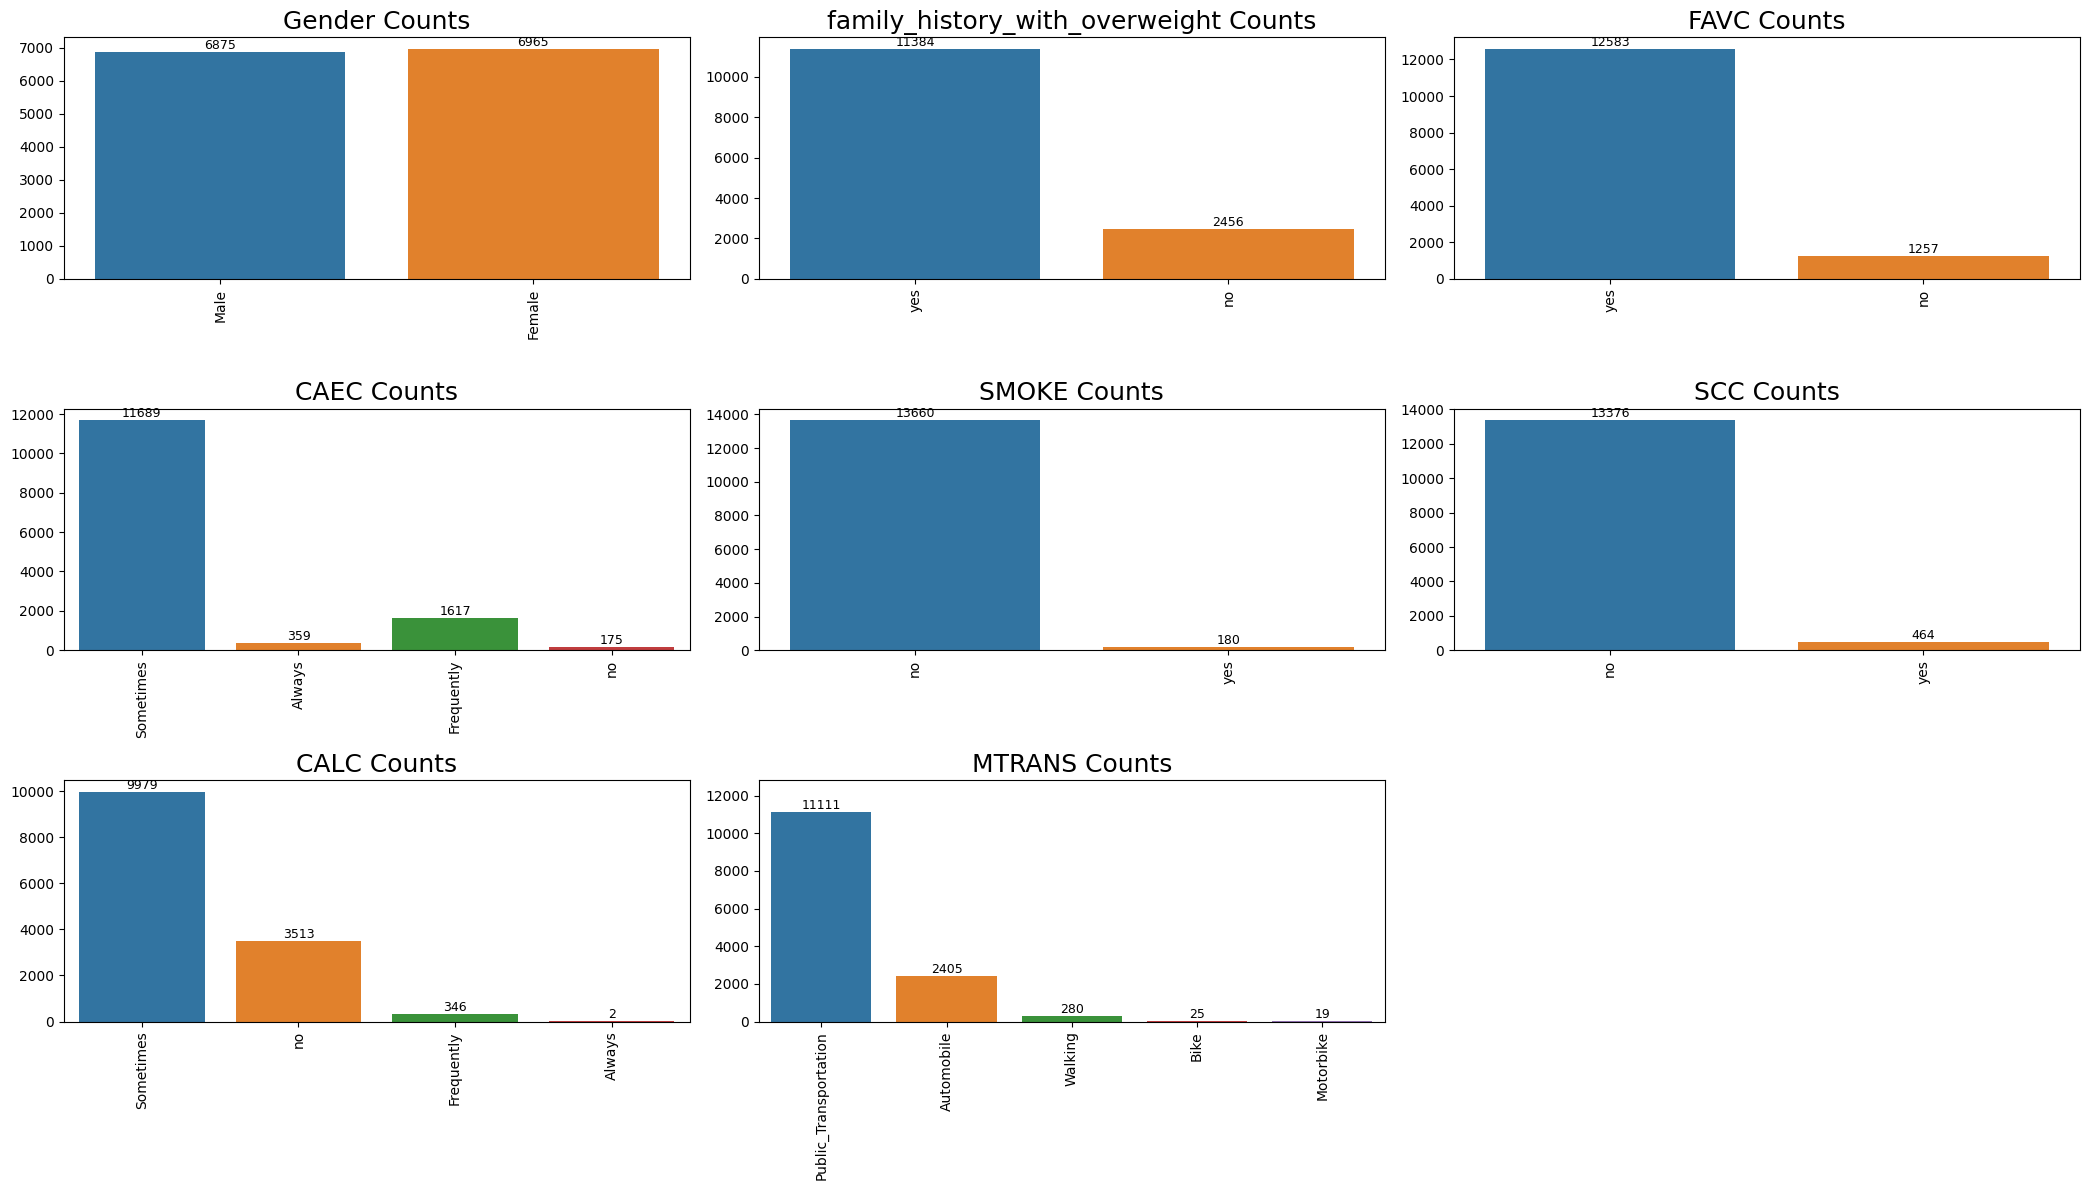

In [15]:
plot_count(df_train,columns_cat,3,None)
plot_count(df_test,columns_cat,3,None)

In [16]:
dist_train=df_train["SMOKE"].value_counts(normalize=True).rename_axis("Unique Values").reset_index(name="%Counts Train")
dist_test=df_test["SMOKE"].value_counts(normalize=True).rename_axis("Unique Values").reset_index(name="%Counts Test") 
dist_cons= pd.merge(dist_train, dist_test,how="inner", on="Unique Values")
dist_cons

,Unique Values,%Counts Train,%Counts Test
0,no,0.988197,0.986994
1,yes,0.011803,0.013006


There is no difference in the distribution of cateogrical variables in test and training data

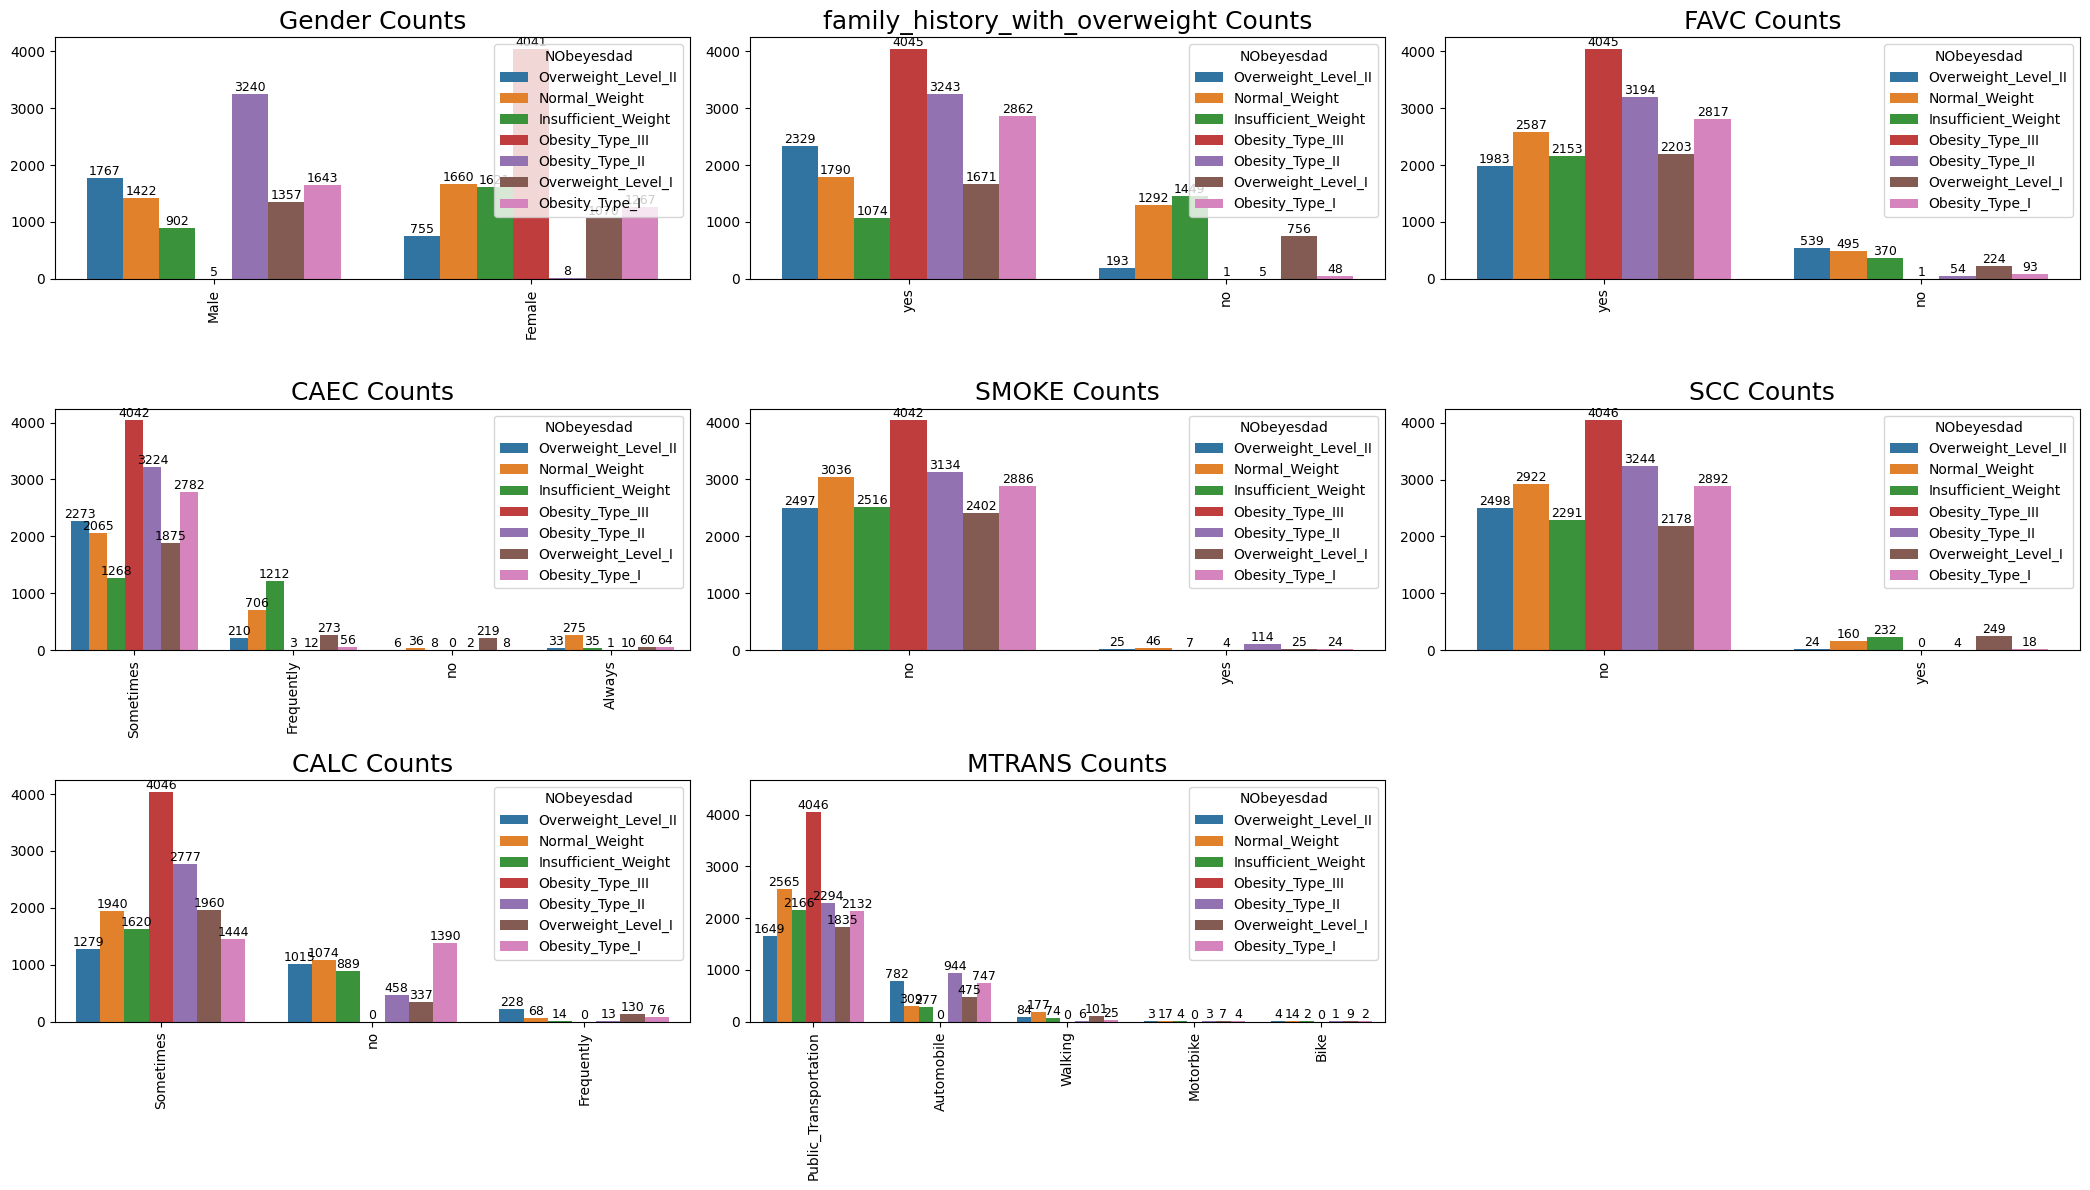

In [17]:
plot_count(df_train,columns_cat,3,"NObeyesdad")

In [18]:
df_train[df_train.select_dtypes(include="object").columns].nunique()

Gender                            2
family_history_with_overweight    2
FAVC                              2
CAEC                              4
SMOKE                             2
SCC                               2
CALC                              3
MTRANS                            5
NObeyesdad                        7
dtype: int64

In [19]:
df_test[df_test.select_dtypes(include="object").columns].nunique()

Gender                            2
family_history_with_overweight    2
FAVC                              2
CAEC                              4
SMOKE                             2
SCC                               2
CALC                              4
MTRANS                            5
dtype: int64

8


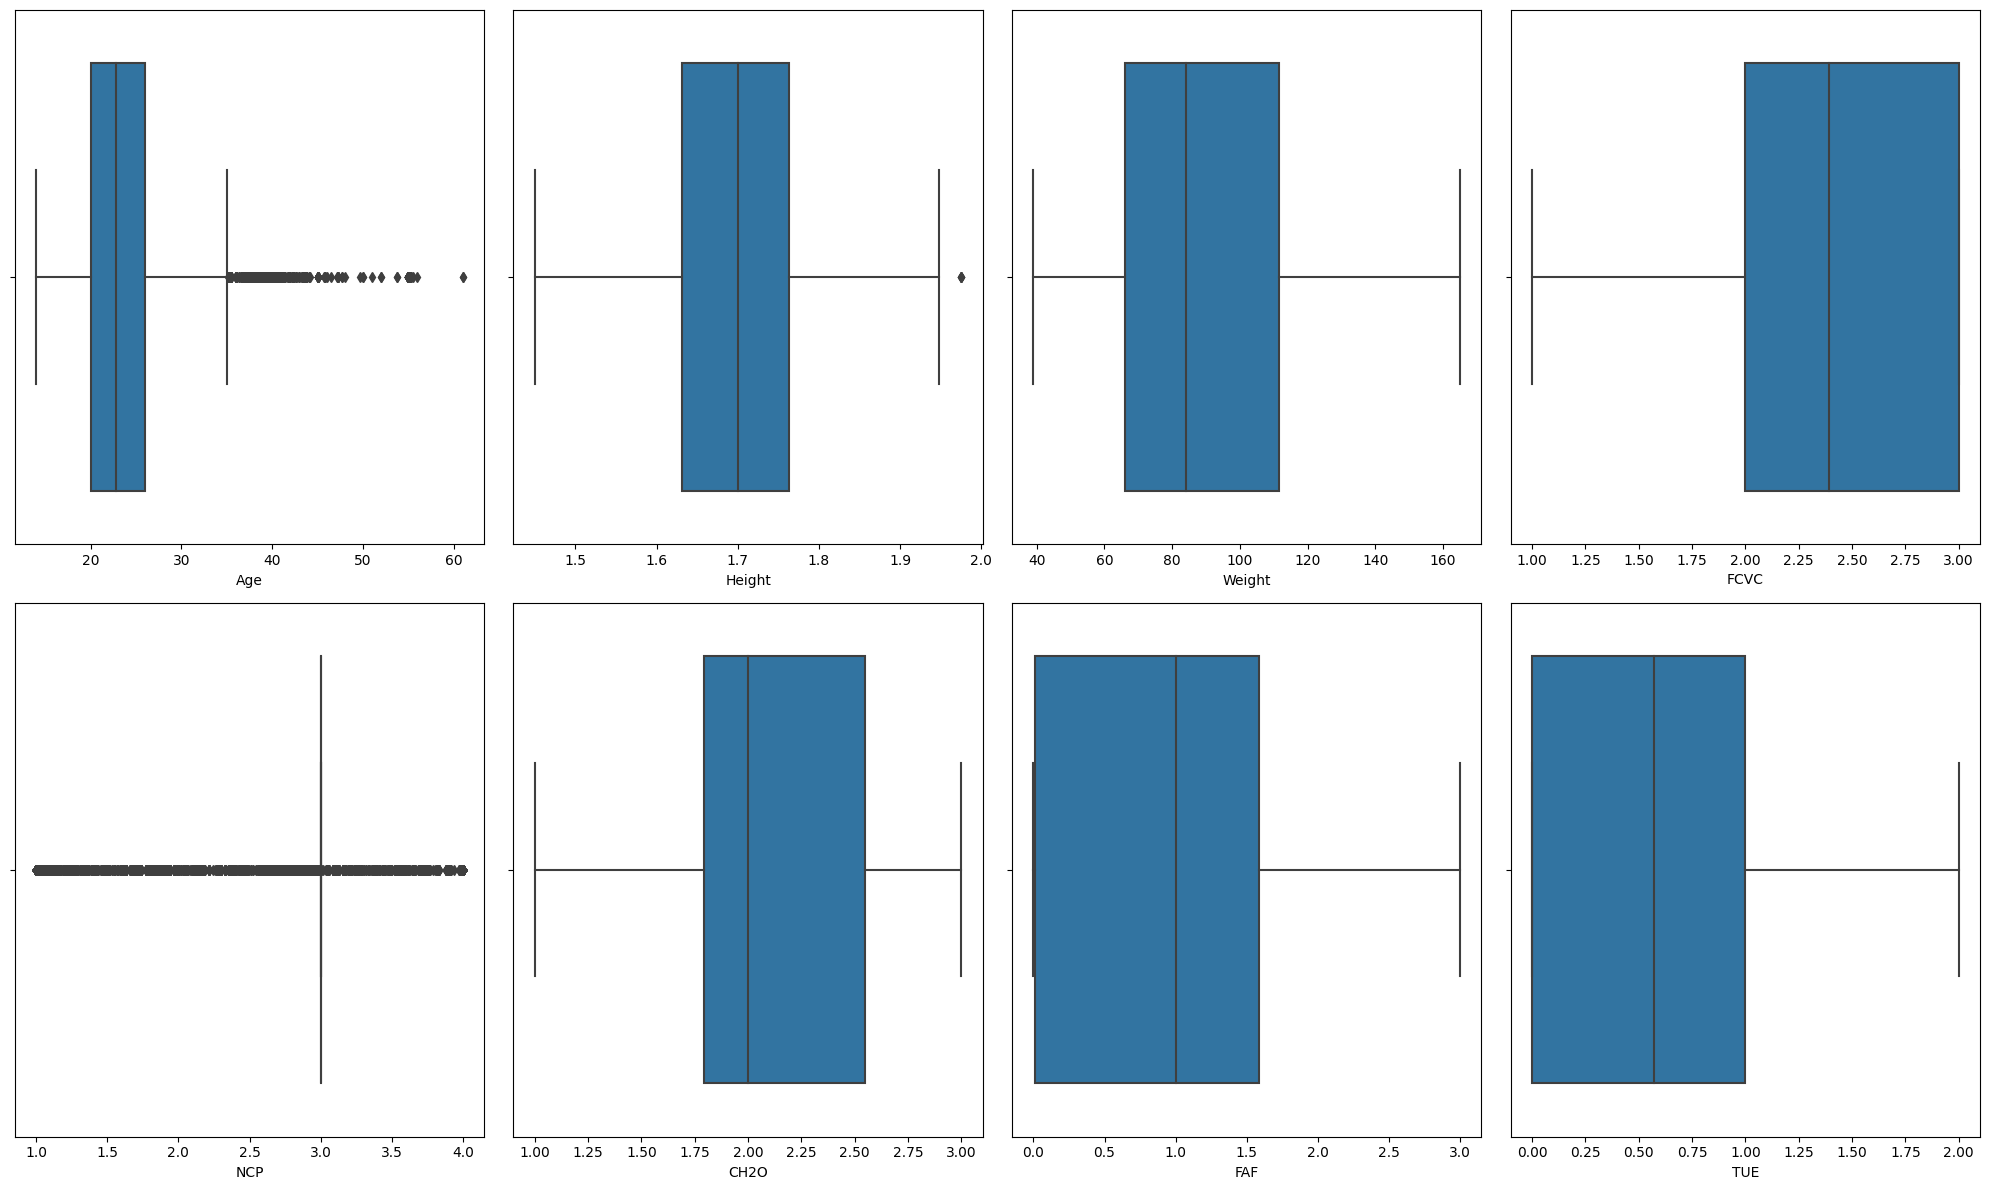

In [20]:
total=len(df_float)
print(total)
i=0
fig,axs=plt.subplots(2,4, figsize=(20,12))
c=0
while(i <total):
    var=df_float[i:i+4]
    #sns.countplot(data=df_train, x="Gender", order=df_train['Gender'].value_counts(ascending=True).index,palette='Set2', ax=axs[0,0])
    sns.boxplot(data=df_train, x=var[0], ax=axs[c,0])
    sns.boxplot(data=df_train, x=var[1], ax=axs[c,1])
    sns.boxplot(data=df_train, x=var[2], ax=axs[c,2])
    sns.boxplot(data=df_train, x=var[3], ax=axs[c,3])
    plt.tight_layout()
    c=c+1
    i=i+4
plt.show()

In [21]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,20758.0,10378.500000,5992.462780,0.00,5189.250000,10378.500000,15567.750000,20757.000000
Age,20758.0,23.841804,5.688072,14.00,20.000000,22.815416,26.000000,61.000000
Height,20758.0,1.700245,0.087312,1.45,1.631856,1.700000,1.762887,1.975663
Weight,20758.0,87.887768,26.379443,39.00,66.000000,84.064875,111.600553,165.057269
FCVC,20758.0,2.445908,0.533218,1.00,2.000000,2.393837,3.000000,3.000000
NCP,20758.0,2.761332,0.705375,1.00,3.000000,3.000000,3.000000,4.000000
CH2O,20758.0,2.029418,0.608467,1.00,1.792022,2.000000,2.549617,3.000000
FAF,20758.0,0.981747,0.838302,0.00,0.008013,1.000000,1.587406,3.000000
TUE,20758.0,0.616756,0.602113,0.00,0.000000,0.573887,1.000000,2.000000


In [22]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,13840.0,27677.500000,3995.408198,20758.00,24217.750000,27677.500000,31137.250000,34597.000000
Age,13840.0,23.952740,5.799814,14.00,20.000000,22.906342,26.000000,61.000000
Height,13840.0,1.698934,0.088761,1.45,1.631662,1.700000,1.760710,1.980000
Weight,13840.0,87.384504,26.111819,39.00,65.000000,83.952968,111.157811,165.057269
FCVC,13840.0,2.442898,0.531606,1.00,2.000000,2.358087,3.000000,3.000000
NCP,13840.0,2.750610,0.710927,1.00,3.000000,3.000000,3.000000,4.000000
CH2O,13840.0,2.032044,0.611230,1.00,1.771781,2.000000,2.552388,3.000000
FAF,13840.0,0.974532,0.840361,0.00,0.001086,1.000000,1.571865,3.000000
TUE,13840.0,0.611033,0.608005,0.00,0.000000,0.552498,1.000000,2.000000


8


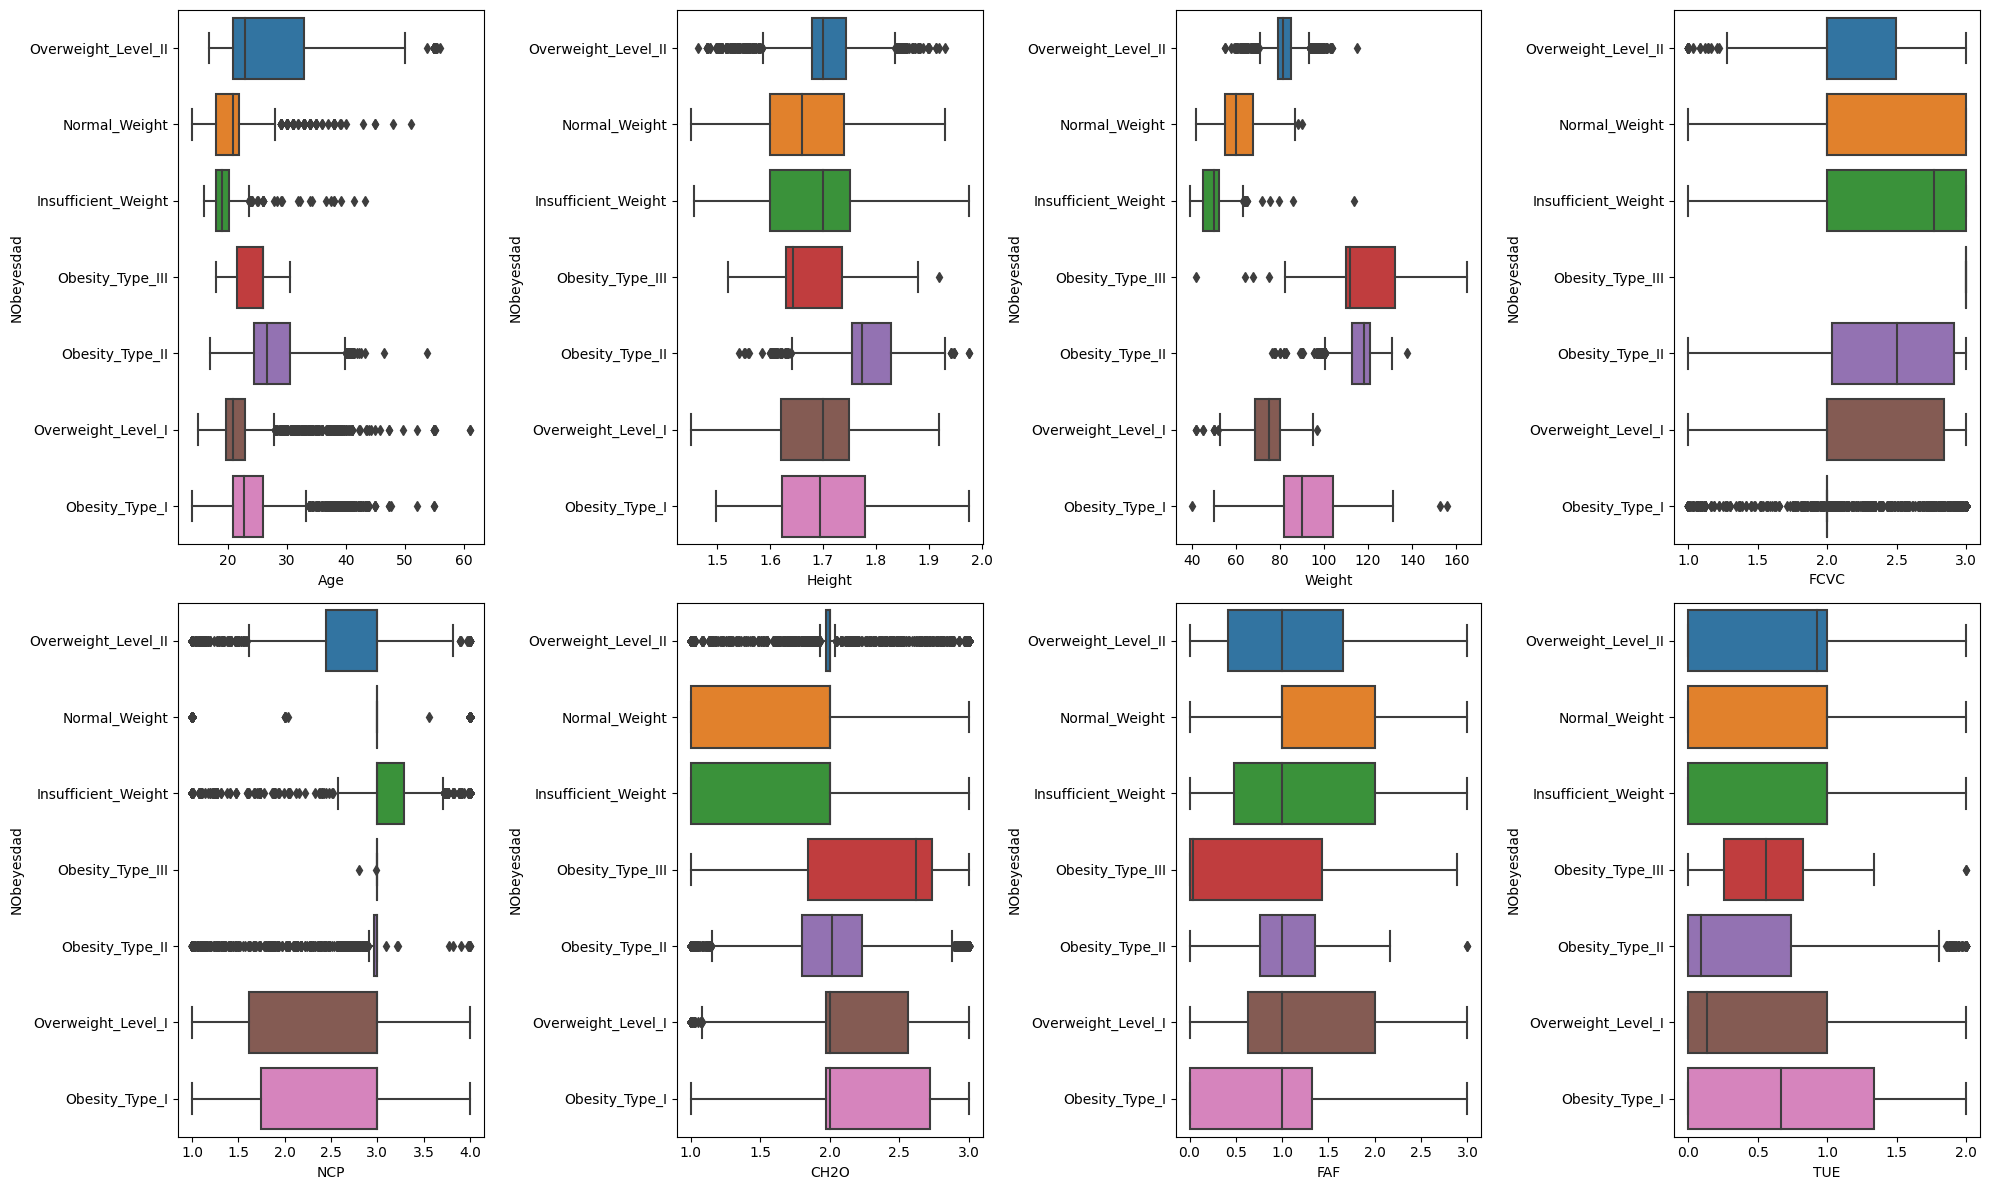

In [23]:
total=len(df_float)
print(total)
i=0
fig,axs=plt.subplots(2,4, figsize=(20,12))
c=0
while(i <total):
    var=df_float[i:i+4]
    #sns.countplot(data=df_train, x="Gender", order=df_train['Gender'].value_counts(ascending=True).index,palette='Set2', ax=axs[0,0])
    sns.boxplot(data=df_train, x=var[0],y="NObeyesdad", ax=axs[c,0])
    sns.boxplot(data=df_train, x=var[1],y="NObeyesdad",  ax=axs[c,1])
    sns.boxplot(data=df_train, x=var[2],y="NObeyesdad",  ax=axs[c,2])
    sns.boxplot(data=df_train, x=var[3],y="NObeyesdad",  ax=axs[c,3])
    plt.tight_layout()
    c=c+1
    i=i+4
plt.show()

In [24]:
def plot_corr_matrix(df, var):
    corr_matrix = df[var].corr()
    print(corr_matrix)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    plt.figure(figsize=(15, 12))
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='Blues', fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9} )
    plt.title('Correlation Matrix', fontsize=15)
    plt.show()

             Age    Height    Weight      FCVC       NCP      CH2O       FAF  \
Age     1.000000 -0.011713  0.283381  0.034414 -0.048479 -0.016325 -0.192259   
Height -0.011713  1.000000  0.416677 -0.071546  0.191383  0.183706  0.295278   
Weight  0.283381  0.416677  1.000000  0.245682  0.095947  0.317914 -0.084845   
FCVC    0.034414 -0.071546  0.245682  1.000000  0.113349  0.101299 -0.089822   
NCP    -0.048479  0.191383  0.095947  0.113349  1.000000  0.080949  0.100871   
CH2O   -0.016325  0.183706  0.317914  0.101299  0.080949  1.000000  0.082932   
FAF    -0.192259  0.295278 -0.084845 -0.089822  0.100871  0.082932  1.000000   
TUE    -0.296154  0.076433 -0.086471 -0.147843  0.067459 -0.010654  0.021213   

             TUE  
Age    -0.296154  
Height  0.076433  
Weight -0.086471  
FCVC   -0.147843  
NCP     0.067459  
CH2O   -0.010654  
FAF     0.021213  
TUE     1.000000  


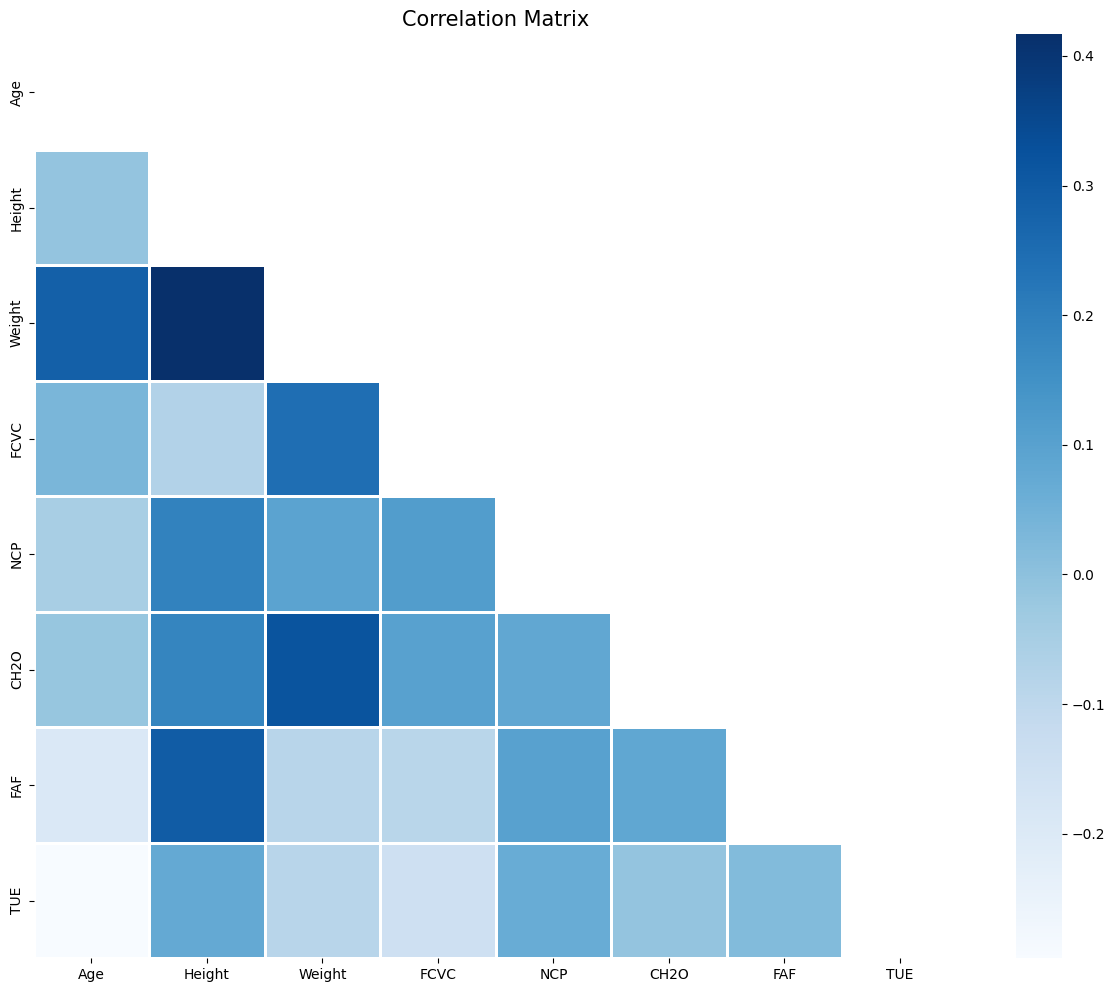

In [25]:
plot_corr_matrix(df_train, df_float)

The highest correlation is between Height and weight

In [26]:
df_train.columns.to_list()

['id',
 'Gender',
 'Age',
 'Height',
 'Weight',
 'family_history_with_overweight',
 'FAVC',
 'FCVC',
 'NCP',
 'CAEC',
 'SMOKE',
 'CH2O',
 'SCC',
 'FAF',
 'TUE',
 'CALC',
 'MTRANS',
 'NObeyesdad']

In [27]:
def chi_squared_test(df, input_var, target_var, significance_level=0.05):
    contingency_table = pd.crosstab(df[input_var], df[target_var])
    chi2, p, _, _ = stats.chi2_contingency(contingency_table)
    
    if p < significance_level:
        print(f'{input_var} has a significant relationship with {target_var}') 
    else:
        print(f'{input_var} does not have a significant relationship with {target_var}') 

for i in df_categorical:
    chi_squared_test(df_train, i, "NObeyesdad")
    
    

Gender has a significant relationship with NObeyesdad
family_history_with_overweight has a significant relationship with NObeyesdad
FAVC has a significant relationship with NObeyesdad
CAEC has a significant relationship with NObeyesdad
SMOKE has a significant relationship with NObeyesdad
SCC has a significant relationship with NObeyesdad
CALC has a significant relationship with NObeyesdad
MTRANS has a significant relationship with NObeyesdad
NObeyesdad has a significant relationship with NObeyesdad


In [28]:
df_train_copy=df_train.copy()
df_test_copy=df_test.copy()

# Feature Engineering

In [29]:
df_train_copy["BMI"]= df_train_copy["Weight"]/(df_train_copy["Height"]*df_train_copy["Height"])
df_train_copy["Phys_Act"]=df_train_copy["FAF"] - df_train_copy["TUE"]
#df_train_copy["ln_Age_BMI"]=np.log(df_train_copy["Age"]/df_train_copy["BMI"])
df_float_new=df_train_copy.select_dtypes(include=["float64"]).columns
df_float_new
#df_train_copy=df_train_copy.drop(columns=["Weight","Height","FAF","TUE"])

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI',
       'Phys_Act'],
      dtype='object')

In [30]:
df_test_copy["BMI"]= df_test_copy["Weight"]/(df_test_copy["Height"]*df_test_copy["Height"])
df_test_copy["Phys_Act"]=df_test_copy["FAF"] - df_test_copy["TUE"]
#df_test_copy["ln_Age_BMI"]=np.log(df_test_copy["Age"]/df_test_copy["BMI"])

               Age    Height    Weight      FCVC       NCP      CH2O  \
Age       1.000000 -0.011713  0.283381  0.034414 -0.048479 -0.016325   
Height   -0.011713  1.000000  0.416677 -0.071546  0.191383  0.183706   
Weight    0.283381  0.416677  1.000000  0.245682  0.095947  0.317914   
FCVC      0.034414 -0.071546  0.245682  1.000000  0.113349  0.101299   
NCP      -0.048479  0.191383  0.095947  0.113349  1.000000  0.080949   
CH2O     -0.016325  0.183706  0.317914  0.101299  0.080949  1.000000   
FAF      -0.192259  0.295278 -0.084845 -0.089822  0.100871  0.082932   
TUE      -0.296154  0.076433 -0.086471 -0.147843  0.067459 -0.010654   
BMI       0.320842  0.098126  0.941071  0.296933  0.048736  0.292142   
Phys_Act  0.016783  0.197231 -0.018655  0.013429  0.043009  0.074324   

               FAF       TUE       BMI  Phys_Act  
Age      -0.192259 -0.296154  0.320842  0.016783  
Height    0.295278  0.076433  0.098126  0.197231  
Weight   -0.084845 -0.086471  0.941071 -0.018655  
FCV

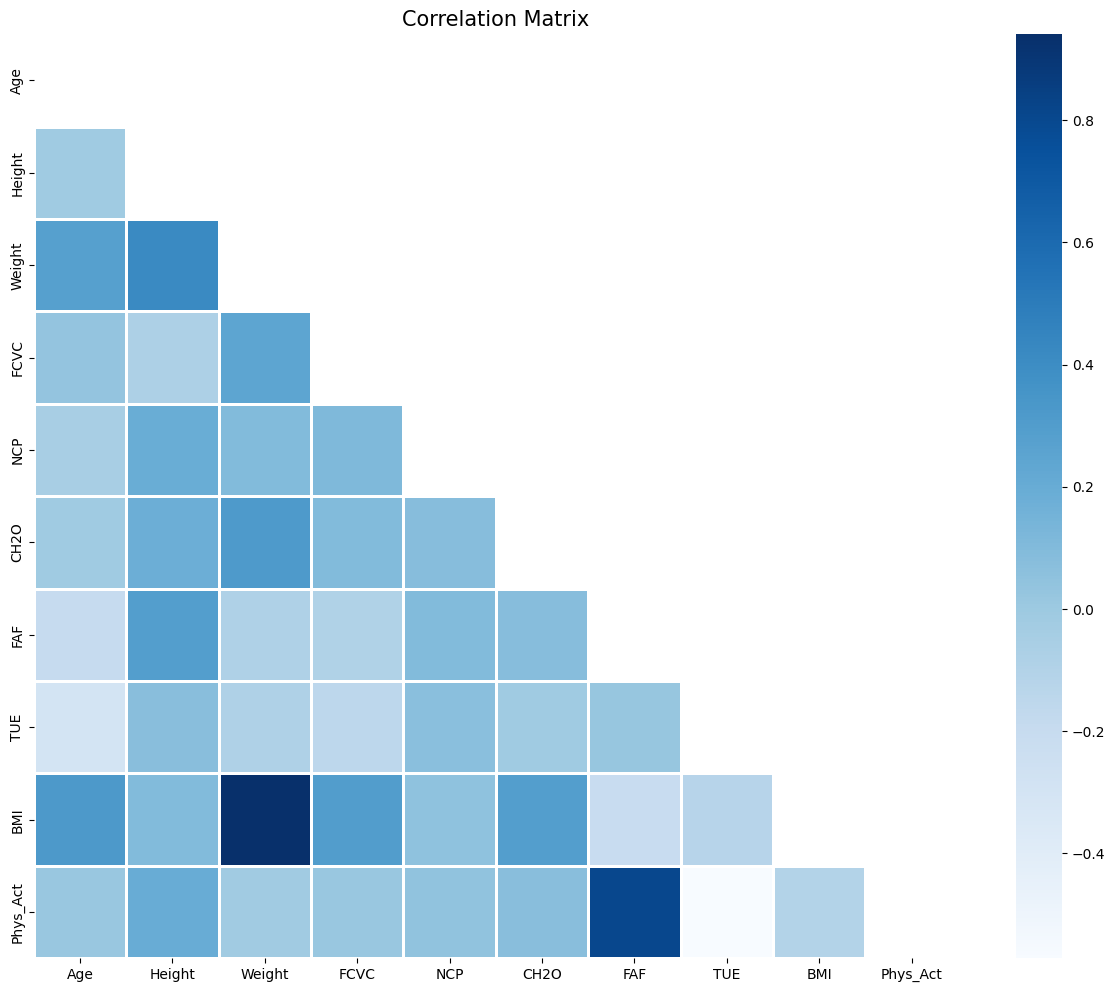

In [31]:
plot_corr_matrix(df_train_copy, df_float_new)

In [32]:
le=LabelEncoder()
df_train_copy["target"]= le.fit_transform(df_train_copy["NObeyesdad"])
df_train_copy["target"].unique()

array([6, 1, 0, 4, 3, 5, 2])

In [33]:
y=df_train_copy["target"]
X=df_train_copy
X=X.drop(columns=["target","NObeyesdad"])

In [34]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
id,20758.0,10378.500000,5992.462780,0.000000,5189.250000,10378.500000,15567.750000,20757.000000
Age,20758.0,23.841804,5.688072,14.000000,20.000000,22.815416,26.000000,61.000000
Height,20758.0,1.700245,0.087312,1.450000,1.631856,1.700000,1.762887,1.975663
Weight,20758.0,87.887768,26.379443,39.000000,66.000000,84.064875,111.600553,165.057269
FCVC,20758.0,2.445908,0.533218,1.000000,2.000000,2.393837,3.000000,3.000000
NCP,20758.0,2.761332,0.705375,1.000000,3.000000,3.000000,3.000000,4.000000
CH2O,20758.0,2.029418,0.608467,1.000000,1.792022,2.000000,2.549617,3.000000
FAF,20758.0,0.981747,0.838302,0.000000,0.008013,1.000000,1.587406,3.000000
TUE,20758.0,0.616756,0.602113,0.000000,0.000000,0.573887,1.000000,2.000000
BMI,20758.0,30.241842,8.333932,12.868541,24.088223,29.384757,37.011168,54.997991


In [35]:
numerical=X.select_dtypes(include=["float64"]).columns
categorical=X.select_dtypes(include=["object"]).columns

In [36]:
numerical_preprocessor=Pipeline(steps=[('scaler',StandardScaler())])
cateogorical_preprocessor=Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])     
preprocessor=ColumnTransformer(transformers=[("num",numerical_preprocessor,numerical),("cat",cateogorical_preprocessor,categorical)])                                

In [37]:
X_train, X_test, y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=40)

# Model Selection - LGBM Classifier

In [38]:
#LGBMClassifier
params= {'max_depth': 29,
 'learning_rate': 0.033428617293743676,
 'n_estimators': 980,
 'feature_fraction': 0.32967518947791724,
 'bagging_fraction': 0.7622417246153894,
 #'reg_alpha': 1.0244020852312212,
 'reg_alpha': 4.0244020852312212,
 'reg_lambda': 1.8041861694589723,
 'num_leaves': 72,
  'verbose': -1}
model=LGBMClassifier(**params)
LGBM_pipeline=Pipeline(steps=[("preprocessor",preprocessor),("model",model)])
LGBM_pipeline.fit(X_train,y_train)
y_pred_train=LGBM_pipeline.predict(X_train)
print(accuracy_score(y_train,y_pred_train))
y_pred_test = LGBM_pipeline.predict(X_test)
print(accuracy_score(y_test,y_pred_test))
#print(classification_report(y_test, y_pred))

0.9489332415691673
0.9100834938985228


# Model Selection - XGB Classifier

In [39]:
#XGB Classifier
from xgboost import plot_importance
params={'max_depth': 53, 
        'learning_rate': 0.03572741775187398,
        'n_estimators': 930, 
        'subsample': 0.7891947616492477,
        'gamma': 0.5757758238000718, 
        'colsample_bytree': 0.44832873923123695,
        'alpha': 1.584032172854192, 
        'lambda': 1.8546182620228922}
model=XGBClassifier(**params)
xgb_pipeline=Pipeline(steps=[("preprocessor",preprocessor),("model",model)])
xgb_pipeline.fit(X_train,y_train)
y_pred_train = xgb_pipeline.predict(X_train)
print(accuracy_score(y_train,y_pred_train))
y_pred_test = xgb_pipeline.predict(X_test)
print(accuracy_score(y_test,y_pred_test))
#print(classification_report(y_test, y_pred))

0.9435650378527185
0.909762363519589


#  Model Selection - CatBoost Classifier

In [40]:
cat_columns=xgb_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical)
feature_importance = pd.Series(data= xgb_pipeline.named_steps['model'].feature_importances_, index = np.array(list(numerical) + list(cat_columns)))
feature_importance=feature_importance.sort_values(ascending=False)
feature_importance

BMI                                   0.160320
Gender_Female                         0.142902
Gender_Male                           0.132917
Weight                                0.100245
FCVC                                  0.050929
family_history_with_overweight_no     0.037076
CAEC_Frequently                       0.027025
family_history_with_overweight_yes    0.024170
CH2O                                  0.023810
CAEC_no                               0.023655
CALC_no                               0.023437
TUE                                   0.019705
Age                                   0.018826
CALC_Sometimes                        0.018422
FAVC_yes                              0.017623
FAVC_no                               0.017168
Height                                0.016837
NCP                                   0.016482
CAEC_Sometimes                        0.016350
MTRANS_Automobile                     0.015932
MTRANS_Public_Transportation          0.014207
SCC_yes      

In [41]:

params={'depth': 6, 
        'learning_rate': 0.26628369559131393,
        'colsample_bylevel': 0.9268328031583585, 
        'l2_leaf_reg': 1.4702276753196513,
        'iterations': 87,
       'verbose': False}

model=CatBoostClassifier(**params)
catb_pipeline=Pipeline(steps=[("preprocessor",preprocessor),("model",model)])
catb_pipeline.fit(X_train,y_train)
y_pred_train = catb_pipeline.predict(X_train)
print(accuracy_score(y_train,y_pred_train))
y_pred_test = catb_pipeline.predict(X_test)
print(accuracy_score(y_test,y_pred_test))

0.9264280798348244
0.8951509312780989


In [42]:
cat_columns=xgb_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical)
feature_importance = pd.Series(data= catb_pipeline.named_steps['model'].feature_importances_, index = np.array(list(numerical) + list(cat_columns)))
feature_importance=feature_importance.sort_values(ascending=False)
feature_importance

BMI                                   25.956412
Weight                                20.322058
Gender_Male                           13.892286
Age                                    7.291243
FCVC                                   6.154389
Height                                 3.510884
TUE                                    3.079929
FAF                                    2.822747
CH2O                                   2.575913
NCP                                    2.486497
Phys_Act                               2.173340
Gender_Female                          1.946385
family_history_with_overweight_no      1.368331
CALC_no                                1.063230
MTRANS_Automobile                      0.942589
CALC_Sometimes                         0.940913
CAEC_Frequently                        0.772283
FAVC_no                                0.584971
MTRANS_Public_Transportation           0.544558
family_history_with_overweight_yes     0.291300
FAVC_yes                               0

# Final Model

In [43]:
final_model = VotingClassifier(
estimators=[('catboost', catb_pipeline), ('xgb', xgb_pipeline), ('lgb', LGBM_pipeline)], voting='soft')

final_model.fit(X, y)


VotingClassifier(estimators=[('catboost',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('num',
                                                                                Pipeline(steps=[('scaler',
                                                                                                 StandardScaler())]),
                                                                                Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI',
       'Phys_Act'],
      dtype='object')),
                                                                               ('cat',
                                                                                Pipeline(steps=[('encoder',
                                                                                                 OneHotEncoder(handle_unknown='ignore'))]),
                                                                                Index(['Gender', 'f...
                                                                                Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS'],
      dtype='object'))])),
                                              ('model',
                                               LGBMClassifier(bagging_fraction=0.7622417246153894,
                                                              feature_fraction=0.32967518947791724,
                                                              learning_rate=0.033428617293743676,
                                                              max_depth=29,
                                                              n_estimators=980,
                                                              num_leaves=72,
                                                              reg_alpha=4.0244020852312214,
                                                              reg_lambda=1.8041861694589723,
                                                              verbose=-1))]))],
                 voting='soft')

In [44]:
predict = final_model.predict_proba(df_test_copy)
#y_pred = final_model.predict(X)

In [45]:
prediction = final_model.predict(df_test_copy)

In [46]:
prediction

array([3, 5, 4, ..., 0, 1, 3])

In [47]:
cat_features = {
    #"CAEC": ['no', 'Sometimes', 'Frequently', 'Always'],
    #"CALC": ['no', 'Sometimes', 'Frequently', 'Always'],
    "NObeyesdad": ['Normal_Weight', 'Insufficient_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']
}

cat_features_inv = {col: dict(zip(range(len(vals)), vals)) for col, vals in cat_features.items()}

In [48]:
sub_data = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')
sub_data["NObeyesdad"] = le.inverse_transform(prediction)
sub_data.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III


In [49]:
sub_data.to_csv('sample_submission.csv', index = False)